# Data collection, cleaning, preprocessing, exploratary plots

## Table of Contents
[ETL](#ETL)
1. [Import packages and raw data](#import-packages-and-raw-data)
2. [Additional Coca-Cola features](#Additional-Coca-Cola-features)
3. [External features](#External-features)
    1. [Company comparisons](#Company-comparisons)
    2. [Macro data](#Macro-data)
    3. [Merge datasets](#Merge-datasets)
4. [Export data](#Export-data)

[EDA](#EDA)
1. [Stock Price Over Time](#Stock-Price-Over-Time)
2. [Correlation Plot](#Correlation-Plot)
3. [Inter company comparisons](#Inter-company-comparisons)
4. [Moving Average Convergence Divergence (MACD)](#Moving-Average-Convergence-Divergence-(MACD))
5. [Relative Strength Index (RSI)](#Relative-Strength-Index-(RSI))
6. [Bollinger Bands](#Bollinger-Bands)

# ETL

## Import packages and raw data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import pandas_datareader.data as web
import datetime as dt 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Imports data

# yyyy, mm, dd
start_date  = dt.datetime(2013, 3, 19)
end_date = dt.datetime(2022, 12, 31)

# load data from yahoo
KO_data = yf.download('KO', start=start_date, end=end_date)

KO_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-19,38.919998,39.400002,38.820000,39.330002,28.699396,15192000
2013-03-20,39.400002,39.919998,39.360001,39.869999,29.093433,19271900
2013-03-21,39.849998,40.430000,39.759998,40.070000,29.239386,23063600
2013-03-22,39.980000,40.279999,39.889999,40.040001,29.217493,16128500
2013-03-25,40.110001,40.250000,39.959999,40.119999,29.275875,15718400
...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,63.334194,6463300
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.721226,7320700
2022-12-28,64.459999,64.650002,63.490002,63.570000,63.086098,7159400


## Additional Coca-Cola features

In [3]:
# Create more features: previous day values, weekday, n-day simple moving averages
KO_data['Prev_Volume'] = KO_data.loc[:, 'Volume'].shift(1)
KO_data['Prev_Close'] = KO_data.loc[:, 'Close'].shift(1)
KO_data['Weekday'] = KO_data.index.weekday + 1
KO_data['200SMA'] = KO_data['Prev_Close'].rolling(200).mean()
KO_data['100SMA'] = KO_data['Prev_Close'].rolling(100).mean()
KO_data['20SMA'] = KO_data['Prev_Close'].rolling(20).mean()

# Remove +/- inf and NaN values 
df = KO_data.replace(np.inf, np.nan).dropna()

df

,Open,High,Low,Close,Adj Close,Volume,Prev_Volume,Prev_Close,Weekday,200SMA,100SMA,20SMA
Date,,,,,,,,,,,,
2014-01-02,41.119999,41.230000,40.509998,40.660000,30.303066,12698600,11729200.0,41.310001,4,40.12285,39.1751,40.1010
2014-01-03,40.680000,40.730000,40.349998,40.459999,30.153999,10403400,12698600.0,40.660000,5,40.12950,39.1801,40.1165
2014-01-06,40.480000,40.590000,40.160000,40.270000,30.012405,11036300,10403400.0,40.459999,1,40.13245,39.1864,40.1210
2014-01-07,40.480000,40.720001,40.290001,40.389999,30.101828,11872300,11036300.0,40.270000,2,40.13345,39.1926,40.1430
2014-01-08,40.439999,40.439999,39.830002,39.939999,29.766455,15339600,11872300.0,40.389999,3,40.13520,39.2012,40.1395
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,63.334194,6463300,9666700.0,63.340000,5,61.79105,60.7863,63.3800
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.721226,7320700,6463300.0,63.820000,2,61.82075,60.7853,63.4365
2022-12-28,64.459999,64.650002,63.490002,63.570000,63.086098,7159400,7320700.0,64.209999,3,61.85220,60.7907,63.5120


## External features

### Company comparisions

In [4]:
# adjusted close comparisons (market volatility index, S&P500, Pepsi, Monster, Coca-Cola Bottling)
comparisons = ['^VIX','^GSPC', '^IXIC', '^DJI', '^FTSE', '^GDAXI', '^N225', '^HSI','GC=F','SB=F', 'PEP', 'MNST', 'COKE', 'AAPL', 'BRK-A', 'XOM', 'SHEL']
comparisons_data = yf.download(comparisons, start=start_date, end=end_date) 

#comparisons_data

[*********************100%***********************]  17 of 17 completed


In [5]:
# update comparisons to only keep adjust close data 
comparisons_data = comparisons_data['Close']

#comparisons_data

### Macro data

In [6]:
cpi = web.DataReader("CPIAUCNS", "fred", start_date, end_date)

#cpi

In [7]:
gdp = web.DataReader("GDP", "fred", start_date, end_date)

#gdp

In [8]:
# download US dollar index data from FRED
usd_index = web.DataReader("DTWEXBGS", "fred", start_date, end_date)

#US dollar index

In [9]:
retail_sales = web.DataReader('RSXFS', 'fred', start_date, end_date)

#US retail sales

In [10]:
# Interpolate GDP data to fill in monthly values
cpi_daily = cpi.resample('D').ffill()
gdp_daily = gdp.resample('D').ffill()
retail_sales_daily = retail_sales.resample('D').ffill()
display(cpi_daily)
display(gdp_daily)
display(retail_sales_daily)

,CPIAUCNS
DATE,
2013-04-01,232.531
2013-04-02,232.531
2013-04-03,232.531
2013-04-04,232.531
2013-04-05,232.531
...,...
2022-11-27,297.711
2022-11-28,297.711
2022-11-29,297.711


,GDP
DATE,
2013-04-01,16699.551
2013-04-02,16699.551
2013-04-03,16699.551
2013-04-04,16699.551
2013-04-05,16699.551
...,...
2022-09-27,25723.941
2022-09-28,25723.941
2022-09-29,25723.941


,RSXFS
DATE,
2013-04-01,367290
2013-04-02,367290
2013-04-03,367290
2013-04-04,367290
2013-04-05,367290
...,...
2022-11-27,595328
2022-11-28,595328
2022-11-29,595328


## Merge datasets

In [11]:
# merge all the data (KO, company comparisons, macro)
merged = pd.merge(df, gdp_daily, left_index=True, right_index=True, how='outer')
merged = pd.merge(merged, comparisons_data, left_index=True, right_index=True, how='outer')
merged = pd.merge(merged, cpi_daily, left_index=True, right_index=True, how='outer')
merged = pd.merge(merged, usd_index, left_index=True, right_index=True, how='outer')
merged = pd.merge(merged, retail_sales_daily, left_index=True, right_index=True, how='outer')

# Fill in missing GDP values with the most recent monthly/ quarterly value
merged['GDP'].fillna(method='ffill', inplace=True)
merged['CPIAUCNS'].fillna(method='ffill', inplace=True)
merged['Adj Close'].fillna(method='ffill', inplace=True)
merged['RSXFS'].fillna(method='ffill', inplace=True)

# Rename the columns 
merged.rename(columns={'CPIAUCNS':'CPI'}, inplace=True)
merged.rename(columns={'^GSPC':'S&P500'}, inplace=True)
merged.rename(columns={'^IXIC':'NASDAQ'}, inplace=True)
merged.rename(columns={'^DJI':'Dow Jones'}, inplace=True)
merged.rename(columns={'^FTSE':'FTSE 100'}, inplace=True)
merged.rename(columns={'^GDAXI':'DAX'}, inplace=True)
merged.rename(columns={'^N225':'Nikkei 225'}, inplace=True)
merged.rename(columns={'^HSI':'Hang Seng Index'}, inplace=True)
merged.rename(columns={'^VIX':'Market Volatility'}, inplace=True)
merged.rename(columns={'GC=F':'Gold'}, inplace=True)
merged.rename(columns={'DTWEXBGS': 'USD Index'}, inplace=True)
merged.rename(columns={'RSXFS':'Retail Sales'}, inplace=True)
merged.rename(columns={'SB=F':'Raw Sugar Futures'}, inplace=True)

# Drop NaN values
merged = merged.dropna()

# Save dates
merged.reset_index(inplace=True)
merged.rename(columns={'index':'Date'}, inplace=True)

# Change 'Date' column to a datetime object
merged.Date = pd.to_datetime(merged.Date)

merged

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Volume,Prev_Close,Weekday,...,FTSE 100,DAX,S&P500,Hang Seng Index,NASDAQ,Nikkei 225,Market Volatility,CPI,USD Index,Retail Sales
0,2014-01-06,40.480000,40.590000,40.160000,40.270000,30.012405,11036300.0,10403400.0,40.459999,1.0,...,6730.700195,9428.000000,1826.770020,22684.150391,4113.680176,15908.879883,13.550000,233.916,93.9109,373327.0
1,2014-01-07,40.480000,40.720001,40.290001,40.389999,30.101828,11872300.0,11036300.0,40.270000,2.0,...,6755.500000,9506.200195,1837.880005,22712.779297,4153.180176,15814.370117,12.920000,233.916,94.0398,373327.0
2,2014-01-08,40.439999,40.439999,39.830002,39.939999,29.766455,15339600.0,11872300.0,40.389999,3.0,...,6721.799805,9497.839844,1837.489990,22996.589844,4165.609863,16121.450195,12.870000,233.916,94.2181,373327.0
3,2014-01-09,39.950001,40.000000,39.520000,39.730000,29.609943,14070200.0,15339600.0,39.939999,4.0,...,6691.299805,9421.610352,1838.130005,22787.330078,4156.189941,15880.330078,12.890000,233.916,94.3299,373327.0
4,2014-01-10,39.959999,40.290001,39.900002,40.130001,29.908060,13290000.0,14070200.0,39.730000,5.0,...,6739.899902,9473.240234,1842.369995,22846.250000,4174.669922,15912.059570,12.140000,233.916,94.0045,373327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,2022-12-22,63.419998,63.590000,62.650002,63.340000,62.857849,9666700.0,10411300.0,63.799999,4.0,...,7469.299805,13914.070312,3822.389893,19679.220703,10476.120117,26507.869141,21.969999,296.797,122.2105,589030.0
1966,2022-12-23,63.500000,63.869999,63.200001,63.820000,63.334194,6463300.0,9666700.0,63.340000,5.0,...,7473.000000,13940.929688,3844.820068,19593.060547,10497.860352,26235.250000,20.870001,296.797,121.9579,589030.0
1967,2022-12-28,64.459999,64.650002,63.490002,63.570000,63.086098,7159400.0,7320700.0,64.209999,3.0,...,7497.200195,13925.599609,3783.219971,19898.910156,10213.290039,26340.500000,22.139999,296.797,121.9983,589030.0
1968,2022-12-29,63.799999,64.150002,63.700001,63.950001,63.463207,7169300.0,7159400.0,63.570000,4.0,...,7512.700195,14071.719727,3849.280029,19741.140625,10478.089844,26093.669922,21.440001,296.797,121.6556,589030.0


## Export data

In [12]:
merged.to_csv('merged_data.csv', index=False)

# EDA 

In [13]:
merged.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Prev_Volume', 'Prev_Close', 'Weekday', '200SMA', '100SMA', '20SMA',
       'GDP', 'AAPL', 'BRK-A', 'COKE', 'Gold', 'MNST', 'PEP',
       'Raw Sugar Futures', 'SHEL', 'XOM', 'Dow Jones', 'FTSE 100', 'DAX',
       'S&P500', 'Hang Seng Index', 'NASDAQ', 'Nikkei 225',
       'Market Volatility', 'CPI', 'USD Index', 'Retail Sales'],
      dtype='object')

In [14]:
merged.describe()

,Open,High,Low,Close,Adj Close,Volume,Prev_Volume,Prev_Close,Weekday,200SMA,...,FTSE 100,DAX,S&P500,Hang Seng Index,NASDAQ,Nikkei 225,Market Volatility,CPI,USD Index,Retail Sales
count,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1.970000e+03,1.970000e+03,1970.000000,1970.000000,1970.000000,...,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000
mean,47.979071,48.311731,47.649294,47.986766,41.815481,1.451295e+07,1.430032e+07,47.971096,3.100000,47.031285,...,6936.395428,12109.721603,2864.447178,24936.694514,8074.054673,21624.715526,18.233797,254.300933,112.111396,455140.620305
std,6.933113,7.004635,6.851477,6.934365,9.445451,6.392529e+06,6.251595e+06,6.928112,1.366229,6.061688,...,512.664996,1799.757706,831.689895,3256.442730,3384.066811,4294.367723,7.726165,17.560649,7.304335,68283.046313
min,37.060001,37.520000,36.270000,37.099998,27.649868,2.996300e+06,2.996300e+06,37.099998,1.000000,39.182750,...,4993.899902,8441.709961,1751.640015,14687.019531,3999.729980,13910.160156,9.220000,233.707000,93.205800,373327.000000
25%,42.340000,42.630001,42.090000,42.389999,34.028623,1.041928e+07,1.027385e+07,42.380001,2.000000,42.010850,...,6647.225098,10658.227295,2102.409912,22801.040039,5065.122437,18474.362305,12.930000,239.261000,110.144150,398128.000000
50%,45.805000,46.075001,45.549999,45.815001,39.019497,1.298905e+07,1.287860e+07,45.799999,3.000000,44.939200,...,7026.899902,12177.135254,2711.594971,24771.584961,7312.119873,21297.009766,16.045000,251.712000,113.329350,435061.000000
75%,53.340000,53.745000,52.939999,53.349998,48.655665,1.671160e+07,1.650020e+07,53.344999,4.000000,50.957537,...,7347.400146,13166.530029,3416.729980,27559.692871,10825.119629,23863.723145,21.570000,260.280000,116.129500,488876.000000
max,67.000000,67.199997,65.720001,66.209999,64.306442,6.784570e+07,6.784570e+07,66.209999,5.000000,61.909300,...,7788.399902,16271.750000,4793.540039,33154.121094,16057.440430,30670.099609,82.690002,298.012000,128.321100,602583.000000


In [15]:
merged

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Volume,Prev_Close,Weekday,...,FTSE 100,DAX,S&P500,Hang Seng Index,NASDAQ,Nikkei 225,Market Volatility,CPI,USD Index,Retail Sales
0,2014-01-06,40.480000,40.590000,40.160000,40.270000,30.012405,11036300.0,10403400.0,40.459999,1.0,...,6730.700195,9428.000000,1826.770020,22684.150391,4113.680176,15908.879883,13.550000,233.916,93.9109,373327.0
1,2014-01-07,40.480000,40.720001,40.290001,40.389999,30.101828,11872300.0,11036300.0,40.270000,2.0,...,6755.500000,9506.200195,1837.880005,22712.779297,4153.180176,15814.370117,12.920000,233.916,94.0398,373327.0
2,2014-01-08,40.439999,40.439999,39.830002,39.939999,29.766455,15339600.0,11872300.0,40.389999,3.0,...,6721.799805,9497.839844,1837.489990,22996.589844,4165.609863,16121.450195,12.870000,233.916,94.2181,373327.0
3,2014-01-09,39.950001,40.000000,39.520000,39.730000,29.609943,14070200.0,15339600.0,39.939999,4.0,...,6691.299805,9421.610352,1838.130005,22787.330078,4156.189941,15880.330078,12.890000,233.916,94.3299,373327.0
4,2014-01-10,39.959999,40.290001,39.900002,40.130001,29.908060,13290000.0,14070200.0,39.730000,5.0,...,6739.899902,9473.240234,1842.369995,22846.250000,4174.669922,15912.059570,12.140000,233.916,94.0045,373327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,2022-12-22,63.419998,63.590000,62.650002,63.340000,62.857849,9666700.0,10411300.0,63.799999,4.0,...,7469.299805,13914.070312,3822.389893,19679.220703,10476.120117,26507.869141,21.969999,296.797,122.2105,589030.0
1966,2022-12-23,63.500000,63.869999,63.200001,63.820000,63.334194,6463300.0,9666700.0,63.340000,5.0,...,7473.000000,13940.929688,3844.820068,19593.060547,10497.860352,26235.250000,20.870001,296.797,121.9579,589030.0
1967,2022-12-28,64.459999,64.650002,63.490002,63.570000,63.086098,7159400.0,7320700.0,64.209999,3.0,...,7497.200195,13925.599609,3783.219971,19898.910156,10213.290039,26340.500000,22.139999,296.797,121.9983,589030.0
1968,2022-12-29,63.799999,64.150002,63.700001,63.950001,63.463207,7169300.0,7159400.0,63.570000,4.0,...,7512.700195,14071.719727,3849.280029,19741.140625,10478.089844,26093.669922,21.440001,296.797,121.6556,589030.0


## Stock Price Over Time

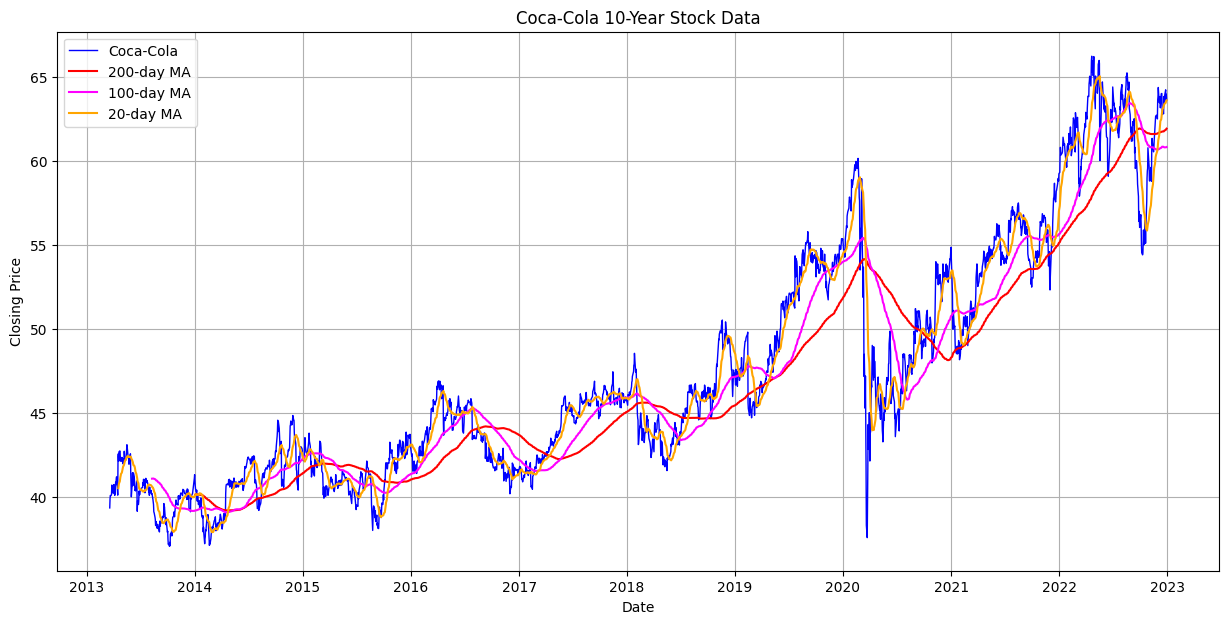

In [16]:
# plot adjusted close and moving averages

# create an array of dates for the x-axis
dates = np.array(KO_data.index)

# plot 
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(dates, KO_data['Close'].to_numpy(), label='Coca-Cola', color='blue',linewidth=1)
plt.plot(dates, KO_data['200SMA'].to_numpy(), label='200-day MA', color='red' )
plt.plot(dates, KO_data['100SMA'].to_numpy(), label='100-day MA', color='magenta')
plt.plot(dates, KO_data['20SMA'].to_numpy(), label='20-day MA', color='orange')

plt.title('Coca-Cola 10-Year Stock Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

plt.show()

## Correlation Plot

In [17]:
# Set the 'Date' column as the index of the DataFrame
merged2 =merged.set_index('Date')
data=merged2.corr()
data

,Open,High,Low,Close,Adj Close,Volume,Prev_Volume,Prev_Close,Weekday,200SMA,...,FTSE 100,DAX,S&P500,Hang Seng Index,NASDAQ,Nikkei 225,Market Volatility,CPI,USD Index,Retail Sales
Open,1.000000,0.998906,0.998659,0.997724,0.987740,0.030977,0.028732,0.998449,0.004642,0.911839,...,0.372236,0.736610,0.882372,-0.117447,0.822566,0.809427,0.335915,0.922625,0.602335,0.902725
High,0.998906,1.000000,0.998179,0.998807,0.989297,0.044170,0.041462,0.997830,0.003330,0.915208,...,0.362527,0.732272,0.882336,-0.120764,0.823099,0.807958,0.352759,0.924388,0.605099,0.903100
Low,0.998659,0.998179,1.000000,0.998895,0.986966,0.009849,0.016835,0.997100,0.004865,0.905370,...,0.385403,0.741620,0.882372,-0.113269,0.821464,0.809974,0.312041,0.919492,0.595042,0.901540
Close,0.997724,0.998807,0.998895,1.000000,0.988511,0.025593,0.030881,0.996449,0.004224,0.909119,...,0.374056,0.735966,0.881856,-0.117966,0.821486,0.807405,0.329924,0.921057,0.598949,0.901355
Adj Close,0.987740,0.989297,0.986966,0.988511,1.000000,0.055764,0.060533,0.986027,0.001870,0.946837,...,0.346152,0.775653,0.924577,-0.091388,0.875320,0.858806,0.394952,0.957140,0.655353,0.939473
Volume,0.030977,0.044170,0.009849,0.025593,0.055764,1.000000,0.515514,0.032846,0.030523,0.115112,...,-0.265045,-0.045835,0.080192,-0.131245,0.106478,0.037675,0.424703,0.087486,0.044391,0.091850
Prev_Volume,0.028732,0.041462,0.016835,0.030881,0.060533,0.515514,1.000000,0.028760,-0.045255,0.120265,...,-0.255257,-0.040648,0.084979,-0.135393,0.109437,0.037611,0.412315,0.094017,0.041131,0.095972
Prev_Close,0.998449,0.997830,0.997100,0.996449,0.986027,0.032846,0.028760,1.000000,0.005575,0.909610,...,0.370797,0.733444,0.879901,-0.117766,0.820015,0.807109,0.340417,0.920835,0.599408,0.901242
Weekday,0.004642,0.003330,0.004865,0.004224,0.001870,0.030523,-0.045255,0.005575,1.000000,-0.004025,...,0.019732,-0.001026,-0.002362,0.010195,-0.005367,-0.003367,-0.031539,-0.002696,-0.002654,-0.003605
200SMA,0.911839,0.915208,0.905370,0.909119,0.946837,0.115112,0.120265,0.909610,-0.004025,1.000000,...,0.241846,0.691193,0.869410,-0.180729,0.824234,0.804669,0.540762,0.964413,0.726151,0.911022


Text(0.5, 1.0, 'Correlation Heatmap')

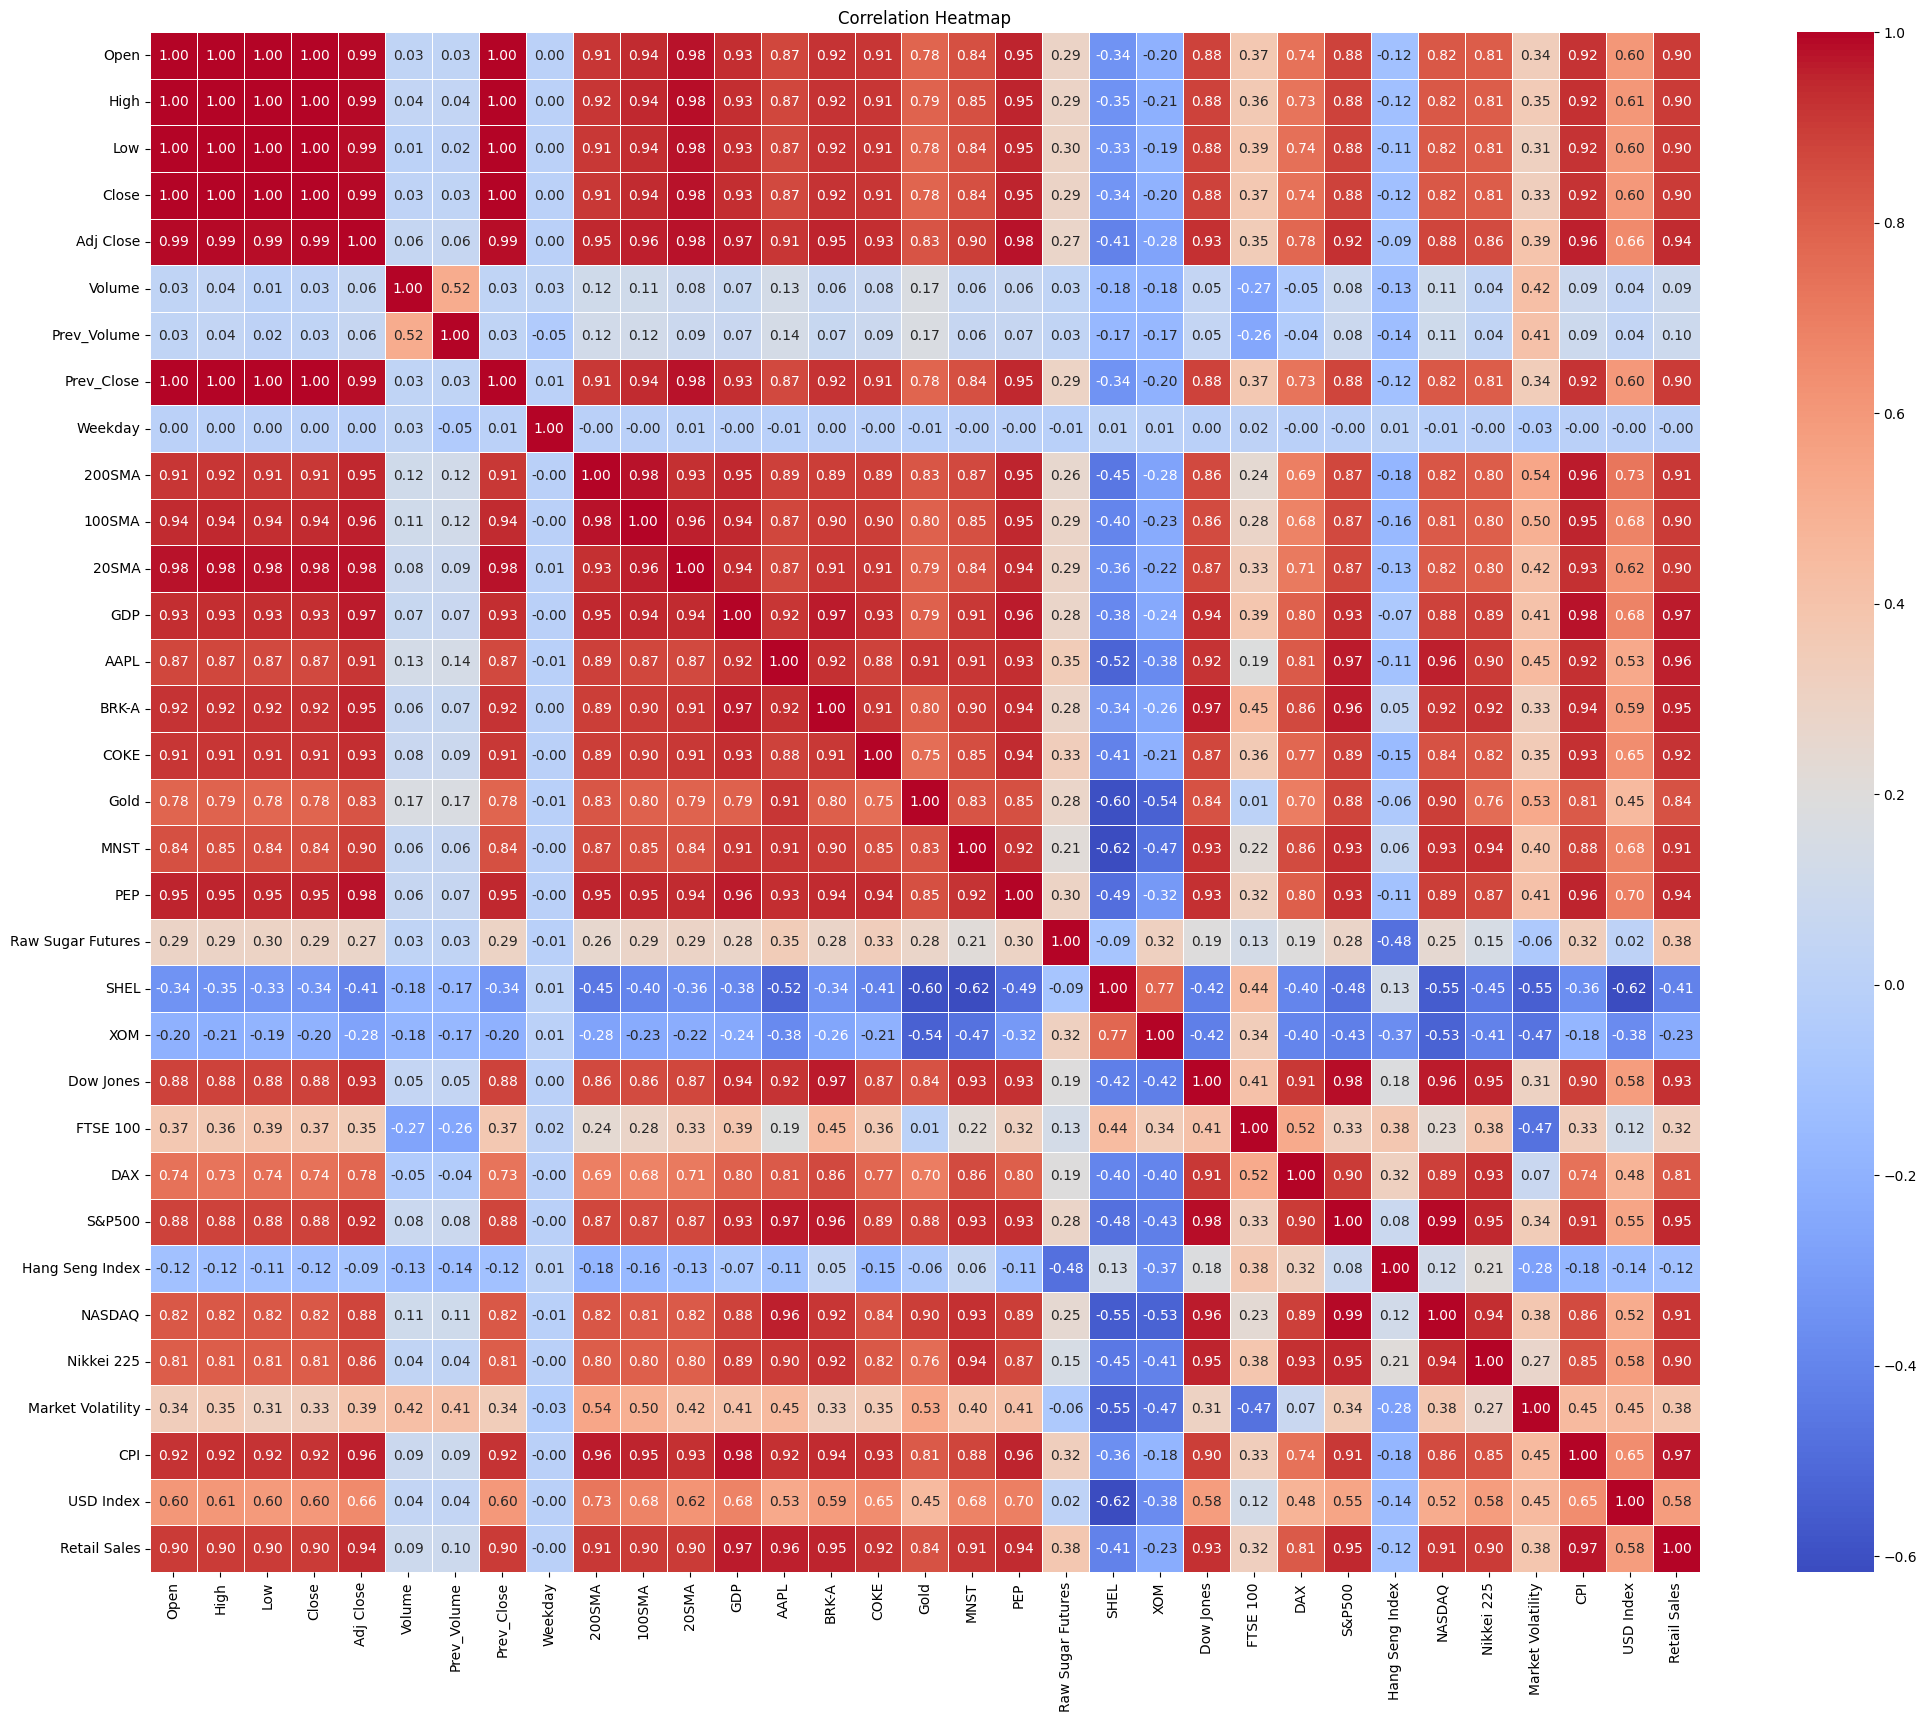

In [18]:
# Set up the figure size
fig, ax = plt.subplots(figsize=(25, 20))
# Generate a heatmap using Seaborn
sns.heatmap(data, annot=True, #Include labels for each square
            cmap='coolwarm', #Set up colour scheme
            fmt='.2f', #Round off values to 2 decimal points
            linewidths=0.5, ax=ax)  # Add lines between cells for better readability
# Set the title
plt.title("Correlation Heatmap")


## Inter company comparisons

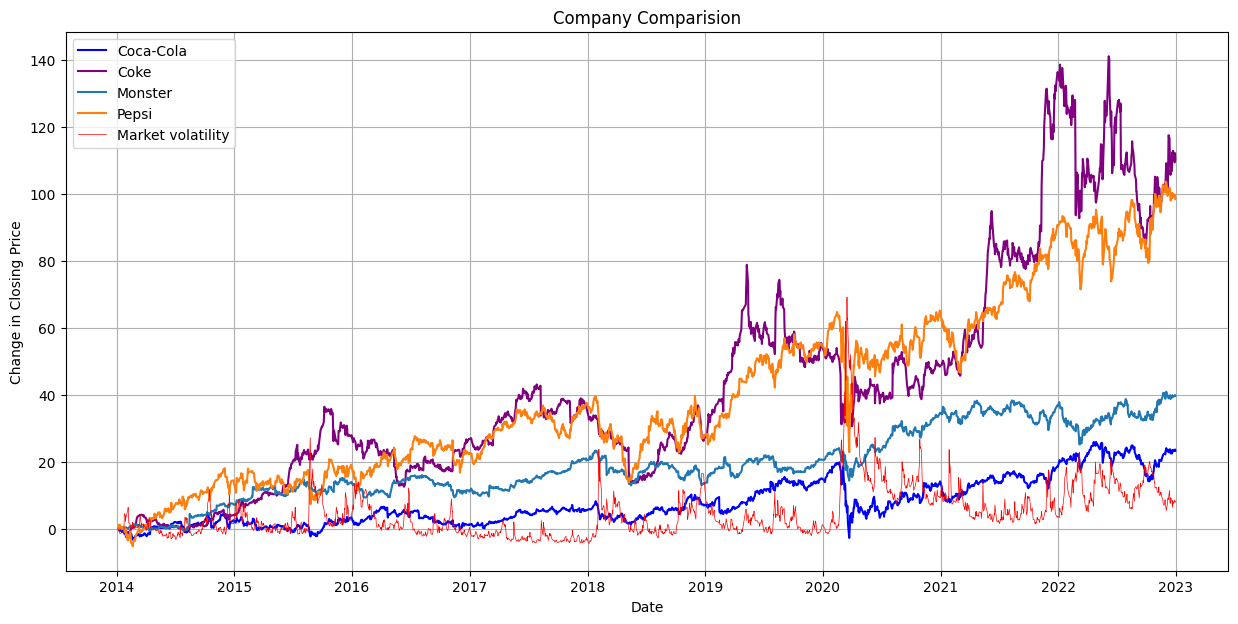

In [19]:
# Update the dates array after removing NaN values
dates = np.array(merged.index)

# y-axis data: relative adjusted close of the comparisons (wrt day1)
change_KO = merged['Close'] - merged['Close'][0]
change_COKE = merged['COKE'] - merged['COKE'][0]
change_MNST = merged['MNST'] - merged['MNST'][0]
change_PEP = merged['PEP'] - merged['PEP'][0]
change_vol = merged['Market Volatility'] - merged['Market Volatility'][0]

# plot
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(merged['Date'].to_numpy(), change_KO.to_numpy(), label='Coca-Cola', color='blue')
plt.plot(merged['Date'].to_numpy(), 0.25*change_COKE.to_numpy(), color='purple', label='Coke')
plt.plot(merged['Date'].to_numpy(), change_MNST.to_numpy(), label='Monster')
plt.plot(merged['Date'].to_numpy(), change_PEP.to_numpy(), label='Pepsi')
plt.plot(merged['Date'].to_numpy(), change_vol.to_numpy(), color='red', linewidth=0.5, label='Market volatility')

plt.title('Company Comparision')
plt.xlabel('Date')
plt.ylabel('Change in Closing Price')
plt.legend()

# set x-axis tick labels


plt.show()

## Moving Average Convergence Divergence (MACD)

This a is a widely-used technical indicator in stock trading that helps traders ***identify potential trend reversals*** and generate trading signals. Traders use the MACD’s histogram to identify when bullish or bearish momentum is high—and possibly overbought/oversold.

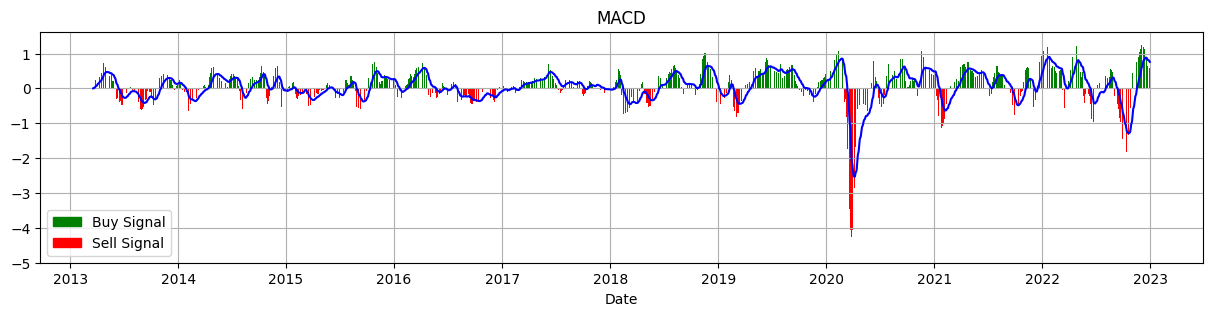

In [20]:
# create an array of dates for the x-axis
dates = np.array(KO_data.index)
#Define MACD function
def calc_macd(KO_data, len1, len2, len3):
  shortEMA = KO_data.ewm(span=len1, adjust=False).mean()
  longEMA = KO_data.ewm(span=len2, adjust=False).mean()
  MACD = shortEMA - longEMA
  signal =  MACD.ewm(span=len2, adjust=False).mean()
  return MACD, signal

MACD, signal = calc_macd(KO_data['Prev_Close'], 12, 26, 9)
KO_data['MACD'] = MACD
KO_data['MACD_signal'] = signal

#Plot MACD graph
plt.figure(figsize=(15,3))
plt.grid(True)
colors = np.array(['green']*len(KO_data['MACD']))
colors[KO_data['MACD']<0] = 'red'
plt.bar(dates, KO_data['MACD'], color=colors, label='Coca-cola')
plt.plot(dates,KO_data['MACD_signal'].to_numpy(), color='blue')
plt.title('MACD')
plt.xlabel('Date')
# Add a legend
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='Buy Signal')
red_patch = mpatches.Patch(color='red', label='Sell Signal')
plt.legend(handles=[green_patch, red_patch])

plt.show()

## Relative Strength Index (RSI) 

This is a popular momentum oscillator in technical analysis that measures the ***speed and change of price movements***. RSI ranges from 0 to 100 and helps traders identify overbought or oversold conditions in the market, potential trend reversals, and generate trading signals. RSI values above 80 are generally considered overbought, indicating that the stock or asset may be overvalued and a price correction or reversal may be imminent. Conversely, RSI values below 20 are considered oversold, suggesting that the stock or asset may be undervalued and a potential buying opportunity.

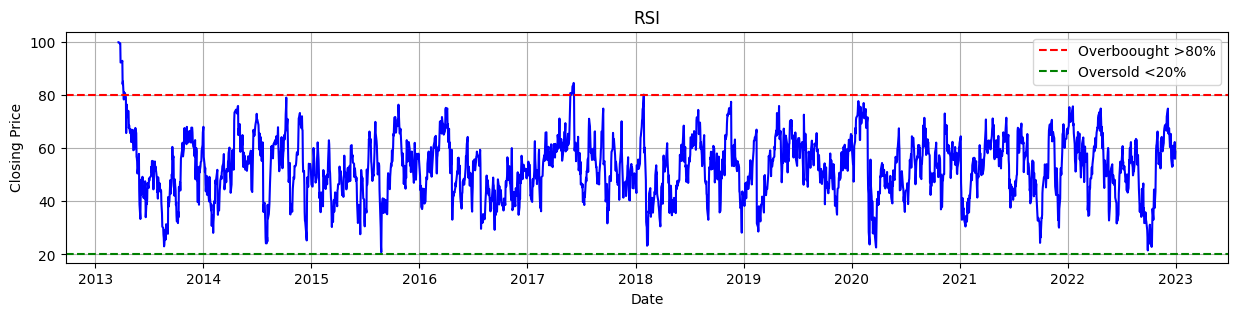

In [21]:
#Define the RSI function 
def calc_rsi(KO_data, period):
  delta = KO_data.diff()
  up = delta.clip(lower=0)
  down = -1*delta.clip(upper=0)
  ema_up = up.ewm(com=period, adjust=False).mean()
  ema_down = down.ewm(com=period, adjust=False).mean()
  rs = ema_up / ema_down
  rsi = 100 - (100/(1+rs))
  return rsi

KO_data['RSI'] = calc_rsi(KO_data['Prev_Close'], 13)
KO_data['RSI_Volume'] = calc_rsi(KO_data['Prev_Volume'], 13)

#Plot RSI graph 
plt.figure(figsize=(15,3))
plt.grid(True)
plt.plot(dates,KO_data['RSI'].to_numpy(), color='blue')
plt.axhline(80, color='red', linestyle='--', label='Overboought >80%')  # Plot overbought level at 80
plt.axhline(20, color='green', linestyle='--', label='Oversold <20%')  # Plot oversold level at 20
plt.legend()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

## Bollinger Bands

This is a widely used indicator that helps traders identify ***potential trend reversals, price volatility, and overbought or oversold market condition***. Bollinger Bands expand and contract based on market volatility, which is represented by the standard deviation of the stock price

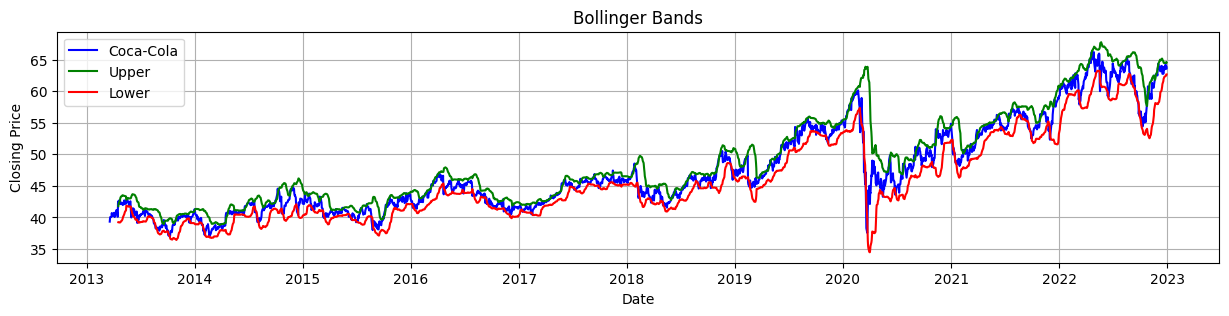

In [22]:
#Define the Bollinger function 
def calc_bollinger(KO_data, period):
  mean = KO_data.rolling(period).mean()
  std = KO_data.rolling(period).std()
  upper_band = np.array(mean) + 2*np.array(std)
  lower_band = np.array(mean) - 2*np.array(std)
  return upper_band, lower_band

upper, lower = calc_bollinger(KO_data['Prev_Close'], 20)
KO_data['Upper Band'] = upper
KO_data['Lower Band'] = lower

# Plot the upper, lower bands 
plt.figure(figsize=(15,3))
plt.grid(True)
plt.plot(dates, KO_data['Close'].to_numpy(), color='blue', label='Coca-Cola')
plt.plot(dates, upper, color='green', label='Upper')
plt.plot(dates, lower, color='red', label='Lower')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Bollinger Bands')
plt.legend()
plt.show()